In [35]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from qRNN import *

In [36]:
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [37]:
def prepare_data(data, time_steps):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return torch.Tensor(x), torch.Tensor(y)

np.random.seed(42)

In [38]:
stock_symbol = "AAPL"
start_date = "2022-01-01"
end_date = "2024-01-01"
stock_data = download_stock_data(stock_symbol, start_date, end_date)

closing_prices = stock_data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

time_steps = 5

x, y = prepare_data(closing_prices_scaled, time_steps)

split_ratio = 0.8
train_size = int(len(x) * split_ratio)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

[*********************100%%**********************]  1 of 1 completed


In [39]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return (labels - predictions) ** 2

def cost(weights, rotations, X):
    loss = 0
    for xs, label in X:
        hidden_state = torch.zeros((1,))
        for x in xs:
            out = circuit(weights, rotations, x, hidden_state)
            prediction = out[0]
            hidden_state = out[1:]
        loss += square_loss(label, prediction)
    
    return loss/batch_size

#train, test = dill.load(open('temperature_processed.pkl', 'rb'))

optimizer = Adam([weights, rotations], lr=0.001)

epoch = 20*10
batch_size = 500


loss_history = []

def accuracy(predicted_sequence, true_sequence):
    return 1-np.mean(np.abs( np.square((predicted_sequence - true_sequence)/true_sequence)) )

def closure():
    batch = random.choices(list(zip(x_train, y_train)), k=batch_size)
    optimizer.zero_grad()
    loss = cost(weights, rotations, batch)
    loss.backward()
    return loss

In [40]:
for i in tqdm(range(epoch)):
    loss = optimizer.step(closure)
    loss_history.append(loss.item())
    if i % 10 == 0 and i > 0:
        print(loss.item())

  6%|▌         | 11/200 [03:25<1:08:49, 21.85s/it]

0.002475256100296974


 10%|█         | 21/200 [07:54<1:19:24, 26.62s/it]

0.0019892167765647173


 16%|█▌        | 31/200 [12:20<1:11:07, 25.25s/it]

0.002251715399324894


 20%|██        | 41/200 [14:39<38:00, 14.34s/it]  

0.001834179856814444


 26%|██▌       | 51/200 [16:56<33:45, 13.59s/it]

0.00235762563534081


 30%|███       | 61/200 [20:33<59:04, 25.50s/it]

0.002121548866853118


 36%|███▌      | 71/200 [22:52<30:09, 14.03s/it]

0.0017259722808375955


 40%|████      | 81/200 [25:54<30:56, 15.60s/it]

0.0020005260594189167


 46%|████▌     | 91/200 [29:32<33:09, 18.25s/it]

0.002035183133557439


 50%|█████     | 101/200 [31:45<22:02, 13.35s/it]

0.0017425990663468838


 56%|█████▌    | 111/200 [33:58<19:39, 13.25s/it]

0.002100556157529354


 60%|██████    | 121/200 [36:13<17:36, 13.37s/it]

0.0019524454837664962


 66%|██████▌   | 131/200 [38:27<15:33, 13.53s/it]

0.001821124111302197


 70%|███████   | 141/200 [40:41<13:11, 13.42s/it]

0.002067774534225464


 76%|███████▌  | 151/200 [42:55<11:01, 13.49s/it]

0.0017917522927746177


 80%|████████  | 161/200 [45:10<08:49, 13.59s/it]

0.0022596840281039476


 86%|████████▌ | 171/200 [47:23<06:25, 13.30s/it]

0.0020601176656782627


 90%|█████████ | 181/200 [49:38<04:13, 13.34s/it]

0.0022243873681873083


 96%|█████████▌| 191/200 [51:53<02:01, 13.47s/it]

0.002385579515248537


100%|██████████| 200/200 [53:54<00:00, 16.17s/it]


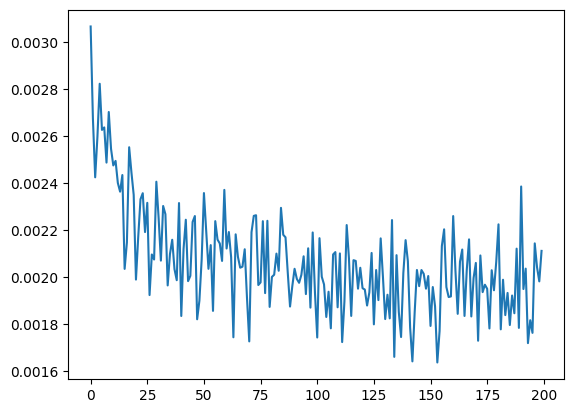

496


In [41]:
plt.plot(loss_history)
plt.show()

print(len(x))

In [42]:
with torch.no_grad():
    predictions = []  
    for stock in x_test:
        hidden_state = torch.zeros((1,))
        for x in stock:
            out = circuit(weights, rotations, x, hidden_state)
            prediction = out[0]
            hidden_state = out[1:]
        predictions.append(prediction)




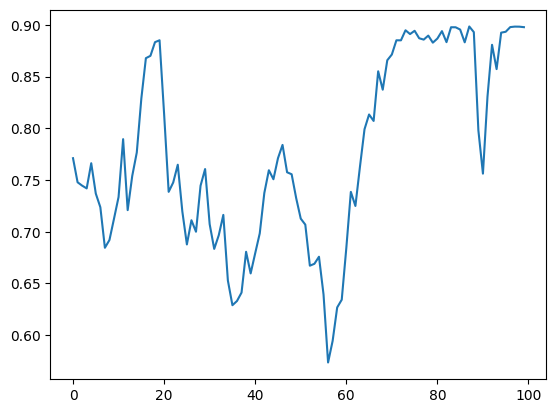

In [43]:
plt.plot(predictions)
predictions = torch.Tensor(predictions)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

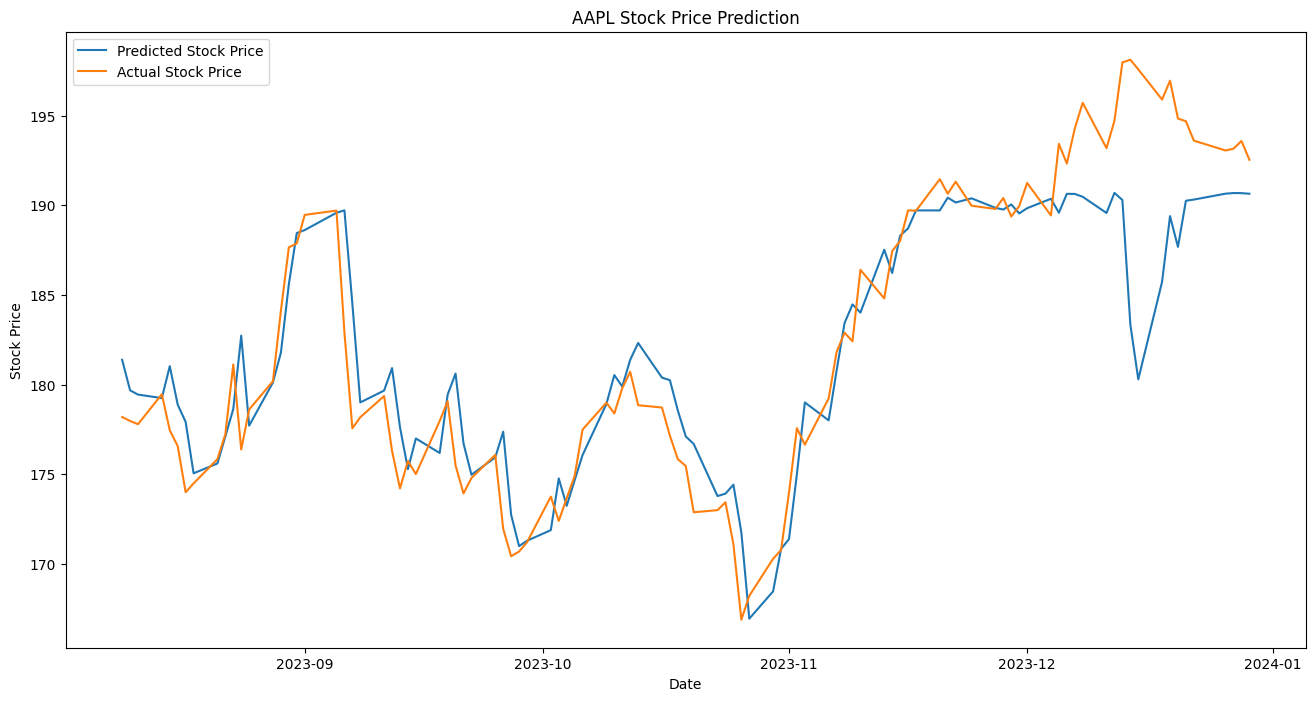

In [44]:
plt.figure(figsize=(16, 8))
plt.plot(stock_data.index[-len(predictions):], predictions, label='Predicted Stock Price')
plt.plot(stock_data.index[-len(predictions):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Stock Price')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [46]:
acc = accuracy(predictions, scaler.inverse_transform(y_test.reshape(-1, 1)))
acc

0.9996102441082405